<a href="https://colab.research.google.com/github/SatouGakuW/dailylog/blob/main/Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.0.0+cu118 0.15.1+cu118


In [35]:
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified
Running on cuda


In [36]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        act = nn.Sigmoid()
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=4, padding=2, stride=2),
            act,
            nn.Conv2d(12, 36, kernel_size=3, padding=1, stride=2),
            act,
            nn.Conv2d(36, 36, kernel_size=3, padding=1, stride=1),
            act,
            nn.Conv2d(36, 36, kernel_size=3, padding=1, stride=1),
            act,
            nn.Conv2d(36, 64, kernel_size=3, padding=1, stride=2),
            act,
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            act
        )
        self.fc = nn.Sequential(
            nn.Linear(3200, 10)
        )

    def forward(self, x):
        x = self.body(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    @staticmethod
    def name():
        return 'CNN6'
    
net = CNN6().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 4. 
Onehot label is 4.


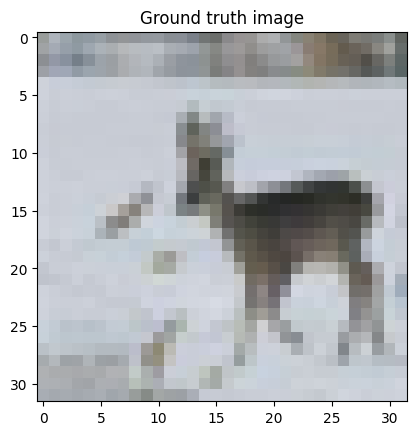

In [37]:
######### honest partipant #########
img_index = 20
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=10)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 8.


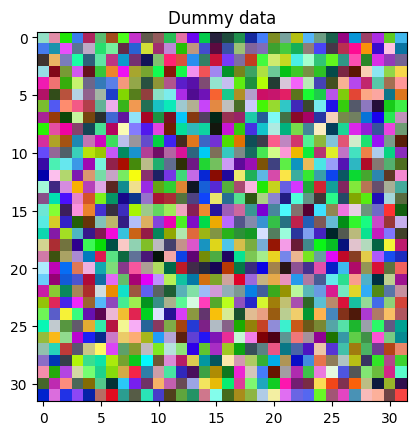

In [38]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [39]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 121.3999
10 11.6661
20 4.7079
30 2.8472
40 1.9358
50 1.4757
60 1.1479
70 0.8968
80 0.7565
90 0.5985
100 0.4942
110 0.3996
120 0.3003
130 0.2158
140 0.1506
150 0.0998
160 0.0555
170 0.0274
180 0.0114
190 0.0039
200 0.0013
210 0.0005
220 0.0002
230 0.0001
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


Dummy label is 4.


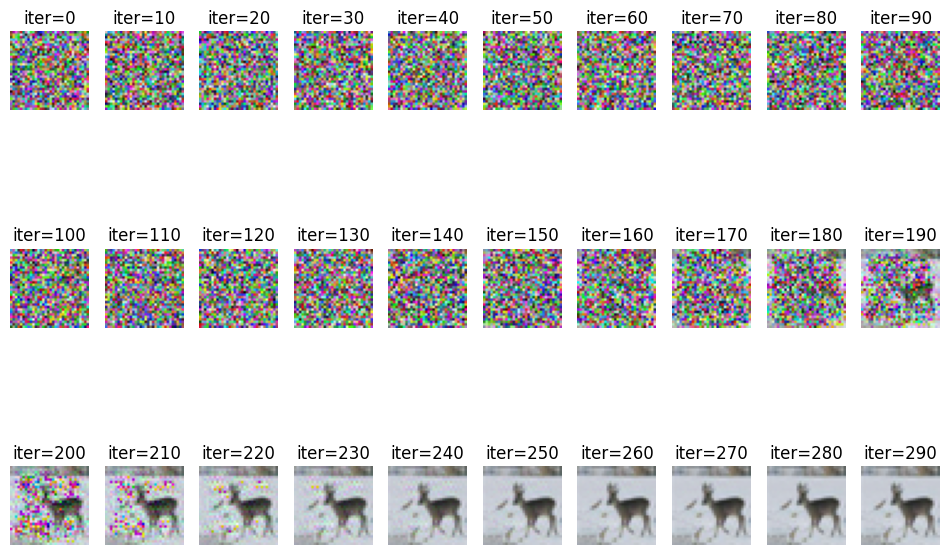

In [40]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())